In [1]:
import numpy as np

### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

In [214]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
        
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        

    def predict(self):
        '''Небольшие изменения метода, используются методы библиотеки numpy.'''
        # получение классов и количество их вхождений
        classes, counts = np.unique(self.labels, return_counts=True)
        
        # получение индекса максимального значения из counts
        idx = np.argmax(counts)
        return classes[idx]

In [215]:
def gini(labels):
    '''Небольшие изменения в функции, используются методы библиотеки numpy.'''
    # получение количества вхождений для каждого класса
    _, counts = np.unique(labels, return_counts=True)
    
    # расчет критерия
    gini = 1 - np.sum((counts/labels.shape[0])**2)
    
    return gini


def gain(left_labels, right_labels, root_gini):
    
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
    
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
    
    return true_data, false_data, true_labels, false_labels


def find_best_split(data, labels, min_samples_leaf=5):
    
    root_gini = gini(labels)
    
    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропуск разбиений, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
                
            current_gain = gain(true_labels, false_labels, root_gini)
            #  порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index
                
    return best_gain, best_t, best_index


def build_tree(data, labels, max_depth=None, min_samples_leaf=1):
    '''В функцию также передаются параметры: 
    max_depth - максимальная глубина,
    min_samples_leaf - минимальное количество объектов в листе.'''
    
    gain, t, index = find_best_split(data, labels, min_samples_leaf=min_samples_leaf)
    
    # возвращает лист, если нет прироста информативности, либо по достижению максимальной глубины
    if gain == 0 or max_depth == 0:
        return Leaf(data, labels)
    
    # убывание значения максимальной глубины для каждого следующего уровня
    if max_depth is not None:
        max_depth -= 1
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    true_branch = build_tree(true_data, true_labels, 
                             max_depth=max_depth, 
                             min_samples_leaf=min_samples_leaf)
    
    false_branch = build_tree(false_data, false_labels, 
                              max_depth=max_depth, 
                              min_samples_leaf=min_samples_leaf)
    
    return Node(index, t, true_branch, false_branch)


def classify_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
    
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [216]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score


classification_data, classification_labels = make_classification(n_samples=500, n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=1234)

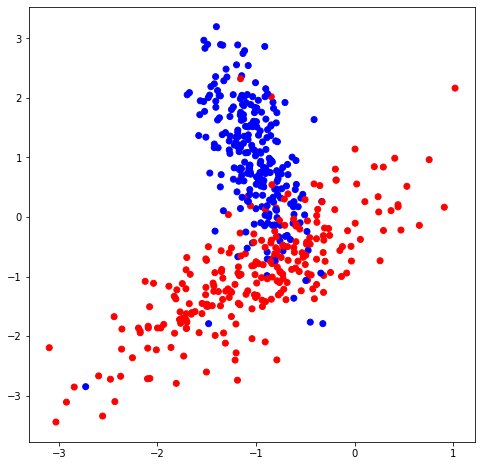

In [217]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [218]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=42)

In [227]:
%%time
my_tree = build_tree(train_data, train_labels, max_depth=3, min_samples_leaf=5)

CPU times: user 244 ms, sys: 0 ns, total: 244 ms
Wall time: 242 ms


In [228]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1 <= -0.15304980554978775
--> True:
  Индекс 1 <= -0.7384007133405865
  --> True:
    Индекс 0 <= -0.638245377322223
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Индекс 0 <= -0.47150301212119017
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
--> False:
  Индекс 0 <= -0.5071795939649821
  --> True:
    Индекс 1 <= 0.3883677064018358
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1
  --> False:
    Индекс 0 <= -0.33363502524913
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0


In [229]:
train_answers = predict(train_data, my_tree)

In [230]:
answers = predict(test_data, my_tree)

In [231]:
train_accuracy = accuracy_score(train_labels, train_answers)
train_accuracy

0.9171428571428571

In [232]:
test_accuracy = accuracy_score(test_labels, answers)
test_accuracy

0.9133333333333333

In [233]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

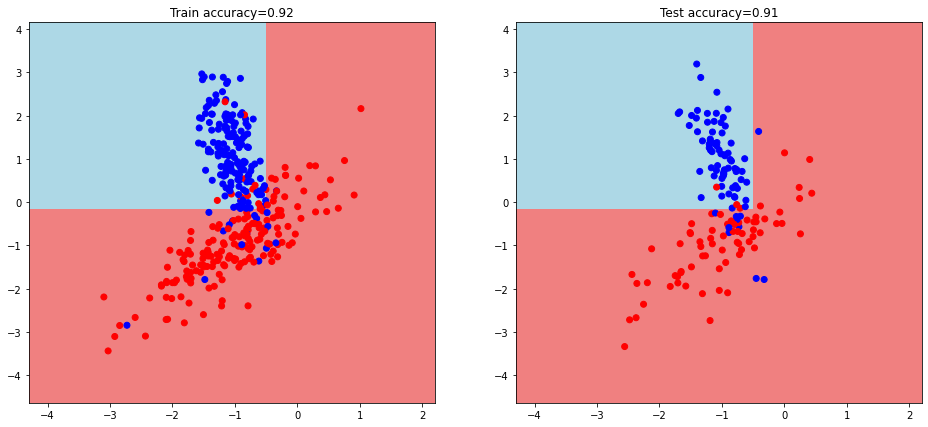

In [234]:
visualize(train_data, test_data)

### 2. * Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [2]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
        
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        

    def predict(self):
        return np.mean(self.labels)

Дисперсия рассчитывается по формуле:

$$ D(y) = \frac{1}{n}\sum_{i = 1}^{n}(y_{i} - \overline{y})^{2} $$

Где $ \overline{y} $ - среднее по $y$

$$ \overline{y} = \frac{1}{n}\sum_{i = 1}^{n}y_{i} $$

Таким образом, функция расчета критерия информативности примет вид

In [3]:
def score(y):
    '''Функция расчета дисперсии значений'''
    mean = np.sum(y)/y.shape[0]
    score = np.sum((y - mean)**2)/y.shape[0]
    return score

Проверка самописной функции

In [4]:
y_ = np.random.randn(10)

In [5]:
score(y_)

0.39145745680164806

In [6]:
np.var(y_)

0.39145745680164806

In [7]:
def score(y):
    '''Функция расчета дисперсии значений'''
    mean = np.sum(y)/y.shape[0]
    score = np.sum((y - mean)**2)/y.shape[0]
    return score


def gain(left_labels, right_labels, root_score):
    
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_score - p * score(left_labels) - (1 - p) * score(right_labels)


def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
    
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
    
    return true_data, false_data, true_labels, false_labels


def find_best_split(data, labels, min_samples_leaf=5):
    ''' Минимальное количество объектов в листе - как параметр функции'''
    
    root_score = score(labels)
    
    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропуск разбиений, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
                
            current_gain = gain(true_labels, false_labels, root_score)
            #  порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index
                
    return best_gain, best_t, best_index


def build_tree(data, labels, max_depth=None, min_samples_leaf=1):
    '''В функцию также передаются параметры: 
    max_depth - максимальная глубина,
    min_samples_leaf - минимальное количество объектов в листе.'''
    
    gain, t, index = find_best_split(data, labels, min_samples_leaf=min_samples_leaf)
    
    # возвращает лист, если нет прироста информативности, либо по достижению максимальной глубины
    if gain == 0 or max_depth == 0:
        return Leaf(data, labels)
    
    # убывание значения максимальной глубины для каждого следующего уровня
    if max_depth is not None:
        max_depth -= 1
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    true_branch = build_tree(true_data, true_labels, 
                             max_depth=max_depth, 
                             min_samples_leaf=min_samples_leaf)
    
    false_branch = build_tree(false_data, false_labels, 
                              max_depth=max_depth, 
                              min_samples_leaf=min_samples_leaf)
    
    return Node(index, t, true_branch, false_branch)


def classify_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
    
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

Проверка на синтетических данных

In [8]:
from sklearn.datasets import make_regression

In [9]:
X, y = make_regression(n_samples=10000, n_features=2, noise=50, random_state=42)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
%%time
regression_tree = build_tree(X_train, y_train, max_depth=5, min_samples_leaf=40)

CPU times: user 7.7 s, sys: 12.5 ms, total: 7.71 s
Wall time: 7.72 s


In [12]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(regression_tree)

Индекс 0 <= 0.15519068385897913
--> True:
  Индекс 0 <= -0.8607291633953384
  --> True:
    Индекс 0 <= -1.515744114997232
    --> True:
      Индекс 0 <= -2.123947582700665
      --> True:
        Индекс 0 <= -2.55254015202075
        --> True:
          Прогноз: -281.9898794565978
        --> False:
          Прогноз: -235.94143385243166
      --> False:
        Индекс 0 <= -1.853018482897569
        --> True:
          Прогноз: -197.95574780351743
        --> False:
          Прогноз: -165.7529078723882
    --> False:
      Индекс 0 <= -1.217403793496952
      --> True:
        Индекс 0 <= -1.3865600587809983
        --> True:
          Прогноз: -147.41136117440743
        --> False:
          Прогноз: -127.08218312418607
      --> False:
        Индекс 1 <= 0.33855287628591424
        --> True:
          Прогноз: -105.14137457265865
        --> False:
          Прогноз: -87.38784068511787
  --> False:
    Индекс 0 <= -0.3393358444160607
    --> True:
      Индекс 0 <= -0.6057149230

Сравнение самописного дерева с DecisionTreeRegresssor из библиотеки sklearn

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

In [14]:
# передаем те же аргументы, что и для самописного дерева
model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=40)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=40)

In [16]:
# самописное дерево
y_pred = predict(X_test, regression_tree)
# дерево из sklearn
y_pred_ = model.predict(X_test)

r2_score

In [18]:
# train
r2_score(y_train, predict(X_train, regression_tree)), r2_score(y_train, model.predict(X_train))

(0.7964182166232351, 0.7964182166232351)

In [19]:
# test
r2_score(y_test, y_pred), r2_score(y_test, y_pred_)

(0.7955782699825875, 0.795426874529264)